Importing Libraries for Deep Learning (TensorFlow), Building Neural Networks (Keras), Visualization (Matplotlib), and Warning Management (Warnings)


In [119]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Defining/setting image processing parameters


In [120]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS = 3

In [121]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\kccha\OneDrive\Desktop\Programming\Potato disease classification\dataset', shuffle=True, image_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [122]:
#Lets's confirm the classes
classname = dataset.class_names
classname

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [123]:
#Let's check one of the images
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 0 1 0 0 0 0 1 2 1 0 1 1 0 1 1 1 0 1 1 1 0 2 1 1 0 0 0 1 1]


Visualisation(let us see) of some of the images from the dataset<h>


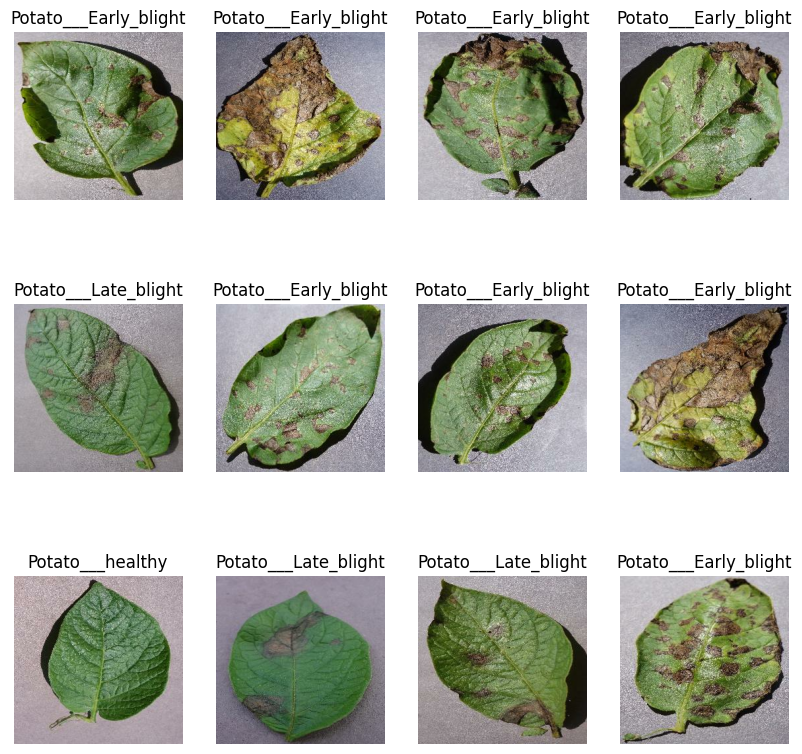

In [124]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classname[labels_batch[i]])
        plt.axis('off')

<h>Next is splitting the dataset, we would separate into the version for training(70% to 80%), testing(10% to 20%) and validation(10%)


In [125]:
#Let's check the length of the dataset
len(dataset)   #it is 32 because it is loading the images in the batch format

68

Let's divide the data now


Let's separate the training data<h>


In [126]:
train_size = 0.8 #training with 80% of dataset ie 80/100 = 0.8
len(dataset)*train_size

54.400000000000006

In [127]:
train_ds = dataset.take(54)
len(train_ds)

54

Next, let's separate the test data


In [128]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [129]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [130]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [131]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [132]:
train_split=0.8
val_split=0.1
test_split=0.1

assert train_split+val_split+test_split == 1

In [133]:
def get_dataset_paratitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split+val_split+test_split == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) #val_size was left as it was same 0.1 as test_size

    return train_ds, val_ds, test_ds 

In [134]:
train_ds, val_ds, test_ds = get_dataset_paratitions_tf(dataset)

In [135]:
len(train_ds)

54

In [136]:
len(val_ds)

6

In [137]:
len(test_ds)

8

Let's put these in a Cache, Shuffle, and Prefetch the dataset


In [138]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Now on to building the model


- Let's begin by data resizing and normalisation


In [139]:
resize_and_rescale = tf.keras.Sequential([
    # layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # layers.experimental.preprocessing.Rescaling(1.0/255) experimental.preprocessing has been removed from latest update to Keras
    layers.Rescaling(1.0/255)
])

- Then, Data Augmentation

In [140]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

- Now on to applying to the trained data

In [141]:
train_ds = train_ds.map(
    lambda x,y : (data_augmentation(x, training=True), y)).prefetch(buffer_size = tf.data.AUTOTUNE)

- On to creating the model architecture

In [142]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Added InputLayer to define input shape
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),  # Removed input_shape from here
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),

    layers.Dense(n_classes, activation='softmax'), 
])

# No need to call model.build() again


- The model's ready, let's check a summary of it before compiling and printing

In [143]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

- Next is compling the model

In [144]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Fitting the model

In [145]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4936 - loss: 0.9192 - val_accuracy: 0.5833 - val_loss: 0.8782
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6995 - loss: 0.6888 - val_accuracy: 0.7500 - val_loss: 0.5806
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8177 - loss: 0.4230 - val_accuracy: 0.8333 - val_loss: 0.3934
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8658 - loss: 0.3375 - val_accuracy: 0.8385 - val_loss: 0.4617
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9093 - loss: 0.2471 - val_accuracy: 0.8438 - val_loss: 0.3189
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8905 - loss: 0.2682 - val_accuracy: 0.9062 - val_loss: 0.1835
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9167 - loss: 0.2072 - val_accuracy: 0.9427 - val_loss: 0.1455
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9500 - loss: 0.1326 - val_accuracy: 0.9167 - val_loss:

Let's save the model

In [159]:
# model.save('potato_disease_model.h5') #Save as Legacy format
model.save('potato_disease_model.keras') #Save as native format as it will be upto date with latest Keras features

Let's evaluate the model

In [160]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9582 - loss: 0.1331


In [161]:
scores

[0.11570422351360321, 0.9609375]

In [162]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [163]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [164]:
type(history.history['loss'])

list

In [165]:
len(history.history['loss'])

10

In [166]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [167]:
val_acc

[0.5833333134651184,
 0.75,
 0.8333333134651184,
 0.8385416865348816,
 0.84375,
 0.90625,
 0.9427083134651184,
 0.9166666865348816,
 0.9166666865348816,
 0.921875]

Let's visualise the loss and accuracy using a graph

Text(0.5, 1.0, 'Training & Validation loss')

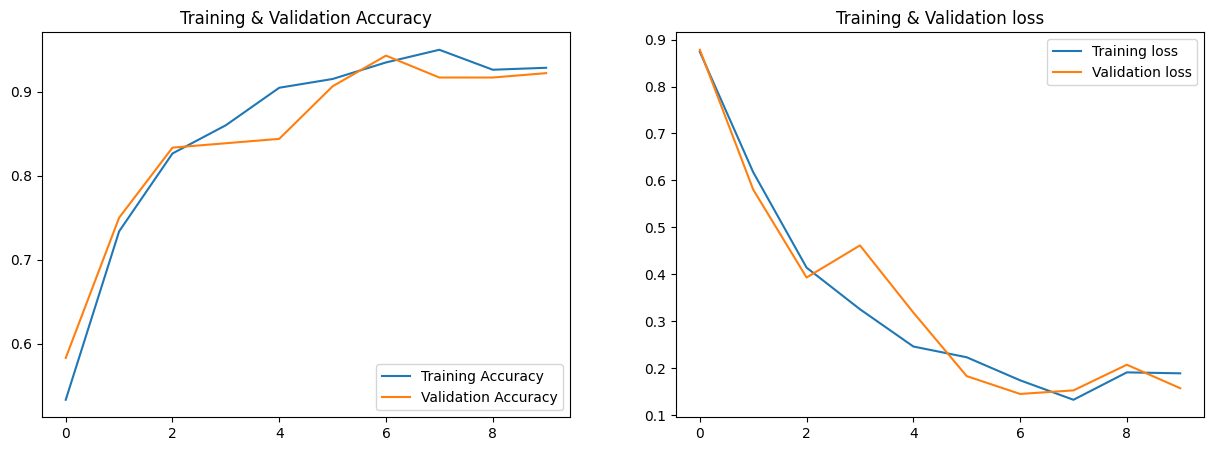

In [168]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label = 'Training Accuracy')
plt.plot(range(10), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label = 'Training loss')
plt.plot(range(10), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training & Validation loss')

Let's test with single images

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
predicted label: Potato___Early_blight


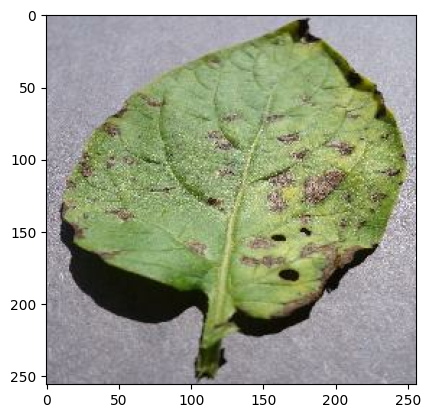

In [169]:
import numpy as np
for image_batch , labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_img)
    print('actual label:', classname[first_label])

    batch_prediction = model.predict(image_batch)
    print('predicted label:', classname[np.argmax(batch_prediction[0])])

Creation of functions for prediction

In [170]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    predicted_class = classname[np.argmax(prediction[0])]
    confidence = round(100 * (np.argmax(prediction[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


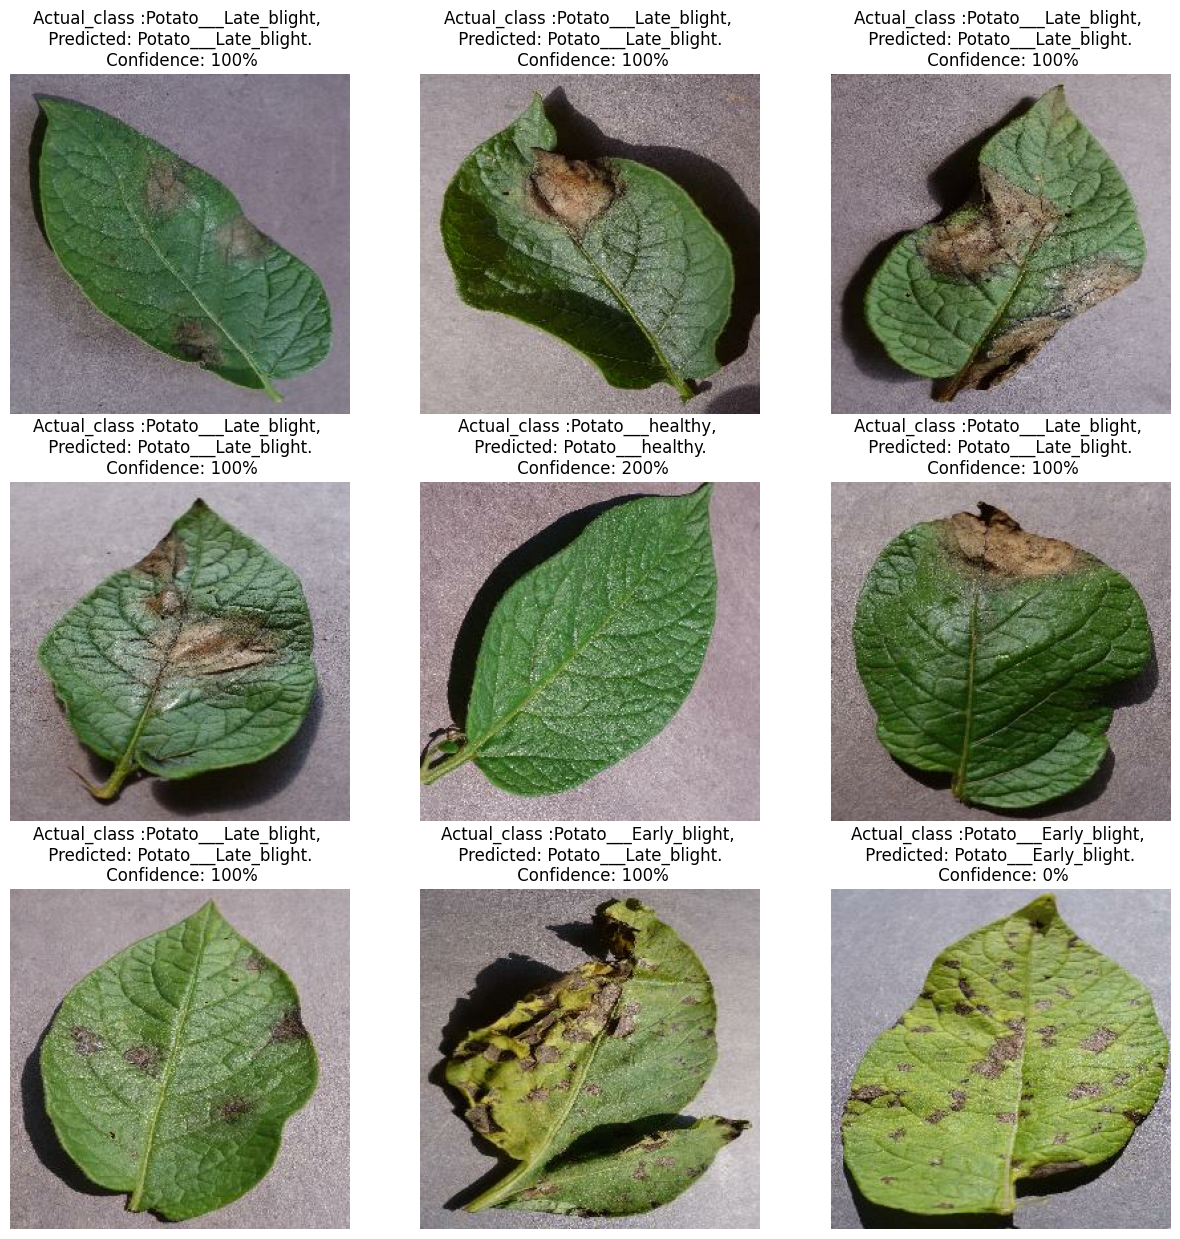

In [171]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i])
        actual_class = classname[labels[i]]

        plt.title(f'Actual_class :{actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%')

        plt.axis('off')

